In [1]:
import yfinance as yf
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from adjustText import adjust_text


# import ccxt
# import ffn
import os
import sys

module_path = os.path.abspath('../') # root directory
if module_path not in sys.path:
    sys.path.append(module_path)

from portfolio_tracker.manager import Stocks, PortfolioManager
from portfolio_tracker.loader import DataLoader
from portfolio_tracker.data_fetching import fetch_stock_prices, fetch_crypto_price, fetch_exchange_rate


# Manually set paths to data files
data_path = module_path + '\\data\\personal_data\\'

type1_PATH = data_path + 'type1.csv'
type2_PATH =  data_path + 'type2.csv'
type3_PATH =  data_path + 'type3.csv'


In [2]:
# Load sample data
type1_df = pd.read_csv(type1_PATH)
# type2_df = pd.read_csv(type2_PATH)
# type3_df = pd.read_csv(type3_PATH)

### Add data

In [27]:
type1_df

,date,security,type_of_asset,action,quantity,total_transaction_price_usd
0,01/01/2023,TSLA,stock,buy,10.0,650
1,01/02/2023,AAPL,stock,buy,5.0,50
2,01/03/2023,BTC,crypto,buy,0.2,3000
3,01/04/2023,VOO,index fund,buy,15.0,4500
4,01/05/2023,ETH,crypto,sell,0.1,2500
5,01/06/2023,TSLA,stock,sell,5.0,325
6,01/08/2023,TSLA,stock,buy,3.0,310
7,01/20/2023,TSLA,stock,sell,4.0,810


In [25]:
from csv import DictWriter

field_names = list(type1_df.columns)
# Dictionary that we want to add as a new row
dict = {'date': '01/20/2023', 'security': 'TSLA', 'type_of_asset': 'stock', 'action': 'sell', 'quantity': 4, 'total_transaction_price_usd': 810}
 
# Open CSV file in append mode
# Create a file object for this file
with open(type1_PATH, 'a') as f_object:
 
    # Pass the file object and a list
    # of column names to DictWriter()
    # You will get a object of DictWriter
    dictwriter_object = DictWriter(f_object, fieldnames=field_names)
 
    # Pass the dictionary as an argument to the Writerow()
    dictwriter_object.writerow(dict)
 
    # Close the file object
    f_object.close()

### Plotting

In [4]:
def plot_portfolio_distribution_3d(owned_assets_dict, current_stock_values):
    """
    Plots a 3D-like pie chart showing the distribution of the portfolio's value among the owned stocks.

    Parameters:
    - owned_assets_dict (dict): Dictionary where keys are stock names and values are total number of shares owned.
    - current_stock_values (dict): Dictionary where keys are stock names and values are current values in USD.
    """
    # Calculate the total value for each stock in the portfolio
    portfolio_values = {stock: owned_assets_dict[stock] * current_stock_values[stock] 
                        for stock in owned_assets_dict}
    
    # Extract the labels and values for the pie chart
    labels = list(portfolio_values.keys())
    sizes = list(portfolio_values.values())
    
    # Define colors for the chart
    colors = plt.cm.tab20.colors  # You can customize this as needed
    
    # Create an 'explode' list to create space between the slices
    explode = [0.05] * len(labels)  # Adjust the explode value to change the gap size

    # Number of layers to create the 3D effect
    layers = 5
    gap = 0.03  # Gap between layers

    fig, ax = plt.subplots(figsize=(8, 8))

    for i in range(layers):
        radius = 1 - i * gap
        if i == 0:
            wedges, texts, autotexts = ax.pie(
                sizes,
                labels=labels,
                autopct='%1.1f%%',
                colors=colors,
                explode=explode,
                startangle=140,
                radius=radius,
                shadow=True,
                wedgeprops=dict(width=0.3, edgecolor='w')
            )
        else:
            wedges, texts = ax.pie(
                sizes,
                labels=None,
                colors=colors,
                explode=explode,
                startangle=140,
                radius=radius,
                shadow=True,
                wedgeprops=dict(width=0.3, edgecolor='w')
            )

    if 'autotexts' in locals():
        # Adjust percentage labels to avoid overlap
        for autotext in autotexts:
            autotext.set_fontsize(8)
            autotext.set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.6))

    # Use adjustText to avoid overlapping labels
    all_texts = texts + autotexts if 'autotexts' in locals() else texts
    adjust_text(all_texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

    ax.set_title("Stock Portfolio Distribution by Current Value")

    plt.show()


In [5]:
def plot_unrealized_gains(unrealized_gains):
    """
    Plots a bar chart of unrealized gains for each asset in the portfolio using Seaborn.

    Parameters:
    - unrealized_gains (dict): A dictionary where keys are stock names and values are unrealized gains in USD.
    """
    # Convert the dictionary to a DataFrame for easier plotting
    df = pd.DataFrame(list(unrealized_gains.items()), columns=['Stock', 'Unrealized Gain'])

    # Set the aesthetic style of the plots
    sns.set_style("whitegrid")

    # Create a seaborn barplot
    plt.figure(figsize=(12, 7))
    barplot = sns.barplot(x='Stock', y='Unrealized Gain', data=df, edgecolor='black')

    # Add title and labels
    plt.title("Unrealized Gains of Current Portfolio", fontsize=16)
    plt.xlabel("Stocks", fontsize=14)
    plt.ylabel("Unrealized Gains (USD)", fontsize=14)
    
    # Rotate x labels for better readability
    # barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=12)

    # Annotate each bar with the gain values
    for p in barplot.patches:
        barplot.annotate(f'{p.get_height():.2f}', 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 10), 
                         textcoords = 'offset points',
                         fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()



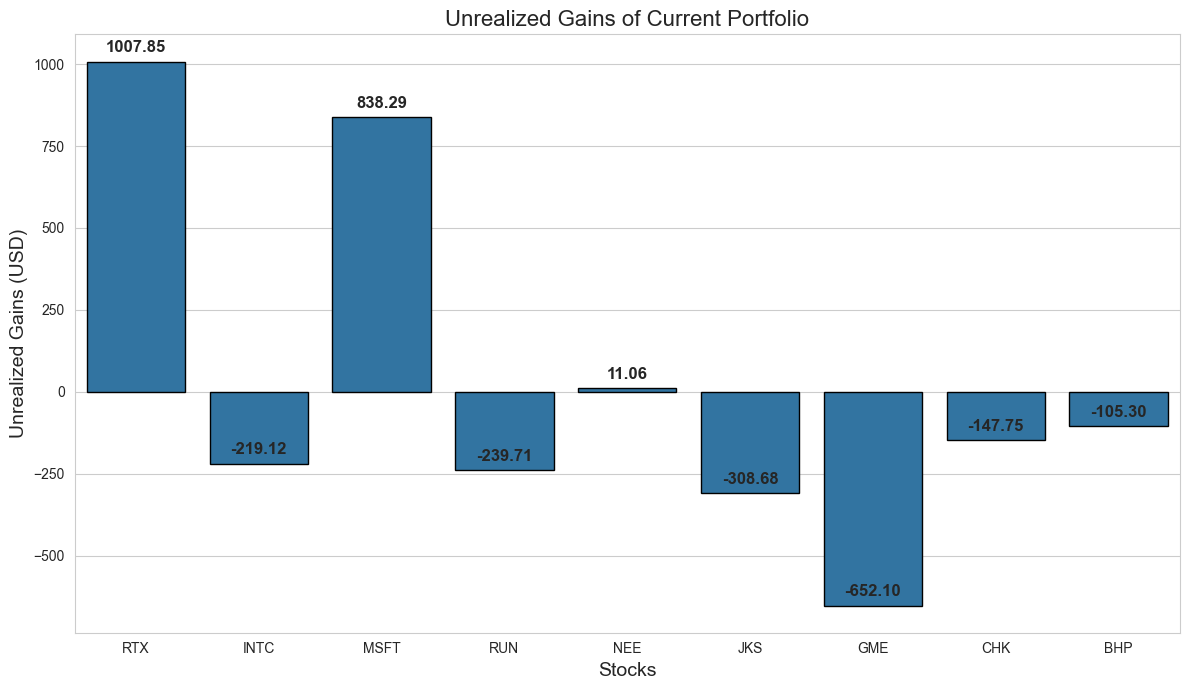

In [48]:
# Call the function to plot the unrealized gains
plot_unrealized_gains(unrealized_gains_dict)


# Stock Data

In [2]:
# Load data
data_loader = DataLoader(type1_PATH)
type1_data = data_loader.get_type1_data()

# Filter only stock transactions
stock_transactions = type1_data.copy() # [type1_data['type_of_asset'] == 'stock']

# Process stock transactions and fetch current values
stocks = Stocks()
stocks.process_transactions(stock_transactions)

owned_assets_dict = stocks.get_owned_assets()
current_stock_values, unrealized_gains_dict = stocks.fetch_current_values()
realized_gains_dict = stocks.get_realized_gains()


In [3]:
plot_portfolio_distribution_3d(owned_assets_dict, current_stock_values)

NameError: name 'plot_portfolio_distribution_3d' is not defined

In [4]:
portfolio_manager = PortfolioManager(stock_transactions)
print("Current Portfolio Value: ", portfolio_manager.current_portfolio_value())
print("Stock Percentages of Portfolio: ", portfolio_manager.stock_percentage_of_portfolio())

Current Portfolio Value:  7208.050016403198
Stock Percentages of Portfolio:  {'RTX': np.float64(34.22284697170762), 'INTC': np.float64(2.4461540489171307), 'MSFT': np.float64(28.93570478140144), 'RUN': np.float64(3.1314988730895927), 'NEE': np.float64(2.2338913285289546), 'JKS': np.float64(1.59321863855761), 'GME': np.float64(14.621152753309023), 'CHK': np.float64(5.167139357680254), 'BHP': np.float64(7.648393246808377)}


In [3]:
import pandas as pd
import yfinance as yf






fetch_exchange_rate('USD', 'GBP', '2023-01-13', '2023-12-25')

,exchange_rate
01/13/2023,0.818480
01/14/2023,0.818480
01/15/2023,0.818480
01/16/2023,0.817880
01/17/2023,0.819150
...,...
12/21/2023,0.791060
12/22/2023,0.788333
12/23/2023,0.788333
12/24/2023,0.788333
